# CS 171 Problem Set 2
# Due Sunday, November 1, 2019 @ 11:59pm

## Read *all* cells carefully and answer all parts (both text and missing code)

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Mohamed Rayyan<br>
Your student ID (submitter): 862037325
</div>


## Overview

In this problem set, we will revisit the same movie review data from last time.  We will first try to predict the numeric score of the review (regression) using ridge regression (problems 1 and 2).  Then, we will try to just predict whether it is a good review or bad review (problems 3 and 4).

The code below imports all allowed libraries and loads the data.  The variables loaded are as follows
- Training data:
    - `trainX` the data matrix, as is standard.  Each feature is a little different from last time.  The ith feature corresponds to the ith most common word across all reviews.  It is still related to the number of times the word is used in the review.  However, this time instead of bucketing this number into a category, we use the real value. Except, that instead of the raw count, we record the number of standard deviations this raw count is away from the mean raw count.  Why?  Well, we will cover that in week 9 or 10.  However, this makes things work better.  So, if the value is 0, then this review uses this word the average number of times.  If the value is +1, this review uses this word one standard deviation higher than average.  If -1, it uses it one standard deviation less than average.
    - `trainYreg` the regression prediciton values.  We don't predict the raw rating (from 0 to 10), but rather the difference of this raw rating and 5.  So if the value in this vector is +3, that means the rating was an 8.  If the value is -4, the actual rating was a 1.
    - `trainYclass` the classification prediction values.  These are +1 for positive reviews and -1 for negative reviews, same as last time.
- Testing data:
    - `testX` same as `trainX` but for the testing set
    - `testYreg` same as `trainYreg` but for the training set
    - `testYclass` same as `trainYclass` but for the training set
    
Note that the X matrices have the "column of all ones" (or the constant feature) already added as the zeroth column.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# load the data
def loadsparsedata(fn):
    
    fp = open(fn,"r")
    lines = fp.readlines()
    maxf = 0;
    for line in lines:
        for i in line.split()[1::2]:
            maxf = max(maxf,int(i))
    
    X = np.zeros((len(lines),maxf))
    Y = np.zeros((len(lines)))
    
    for i, line in enumerate(lines):
        values = line.split()
        Y[i] = int(values[0])
        for j,v in zip(values[1::2],values[2::2]):
            X[i,int(j)-1] = int(v)
    
    X = (X-X.mean(axis=0))/X.std(axis=0)
    return X,Y

def loadplusones(fn):
    (X,Y) = loadsparsedata(fn)
    X = np.column_stack((np.ones(X.shape[0]),X))
    return X,Y

(trainX,trainYreg) = loadplusones('sptrainreal.txt')
(testX,testYreg) = loadplusones('sptestreal.txt')
trainYreg = trainYreg - 5
testYreg = testYreg - 5
trainYclass = np.sign(trainYreg)
testYclass = np.sign(testYreg)

<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part I: Ridge Regression</font>
</div>

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 1:</font> <font size=+1>(3 points)</font>
    
Complete the training and testing functions below for ridge regression.
    
Do **not** penalize the initial weight (corresponding to the intercept term).

</div>

In [2]:
def learnridge(X,Y,lam):
    # X is the data matrix of shape (m,n)
    # Y is are the target values of shape (m,)
    # lam is the value of lambda (careful, lambda is a reserved keyword in python)
    # function should return w of shape (n,)
    
    #YOUR CODE HERE
    A =(X.T @X)
    c =(X.T @Y)
    I =np.identity(len(A))
    I[0][0] =0
    w =np.linalg.solve((A +lam *I), c)
    
    return w

def predictridge(X,w):
    # X is the (testing) data of shape (m,n)
    # w are the weights learned in ridge regression
    # function should return Y, the predicted values of shape (m,)
    
    # YOUR CODE HERE
    return X @w
    Y =[]
    for i in range(len(X)):
        Y.append(X[i]@w)
    
    return Y
    

def testridge(X,Y,w):
    # X and Y are the testing data
    # w are the weights from ridge regression
    # returns the mean squared error
    Ydelta = Y - predictridge(X,w)
    return (Ydelta*Ydelta).mean()


<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 2:</font> <font size=+1>(5 points)</font>

Use 3-fold cross validation to select the value of lambda for ridge regression, using `trainX` and `trainYreg`.  Plot the average across the three folds of the average squared error on the validation set as a function of lambda.  Use `plt.semilogx` for your plot (i.e., the horizontal axis for lambda should be on a log scale).  Use 10 values of lambda, arrange logarithmically evenly between $10^2$ and $10^5$.  See `np.logspace`.  If the number of data points does not divide by 3 evenly, just divide as evenly as possible.  `np.array_split` might help, but there are other ways.
    
Save the chosen value for lambda in `ridgelam`
</div>

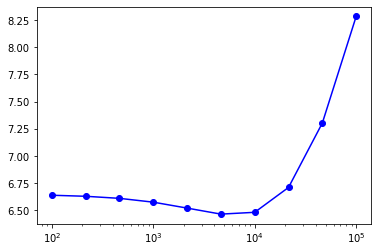

In [38]:
#YOUR CODE HERE
def arrangeMat(X, Y):
    x0, x1, x2 =np.array_split(X, 3)
    y0, y1, y2 =np.array_split(Y, 3)
    
    tmpX =[]
    tmpX.append((x0,np.concatenate((x1,x2),0)))
    tmpX.append((x1,np.concatenate((x0,x2),0)))
    tmpX.append((x2,np.concatenate((x0,x1),0)))
    
    tmpY =[]
    tmpY.append((y0,np.concatenate((y1,y2),0)))
    tmpY.append((y1,np.concatenate((y0,y2),0)))
    tmpY.append((y2,np.concatenate((y0,y1),0)))
    
    return (tmpX,tmpY)

lams =np.logspace(2, 5, num=10)
ridgelam =0
def kfoldRR(x,y):
    kx,ky =arrangeMat(x,y)
    tmpEX =[]
    tmpEY =[]
    lamErr =float('inf')

    for i in range(len(lams)):
        tmpErr =float('inf')
        for k in range(len(kx)):
            for j in range(1,len(kx[0])):
                tmpW =learnridge(kx[k][j],ky[k][j],lams[i])
                err =testridge(kx[k][0],ky[k][0],tmpW)
                if(err <tmpErr):
                    tmpErr =err
            if(tmpErr <lamErr):
                lamErr =tmpErr
                ridgelam =lams[i]
        tmpEX.append(lams[i])
        tmpEY.append(tmpErr)


    plt.semilogx(tmpEX,tmpEY,'bo-')
    plt.show()
    #print('ridgelam =={}'.format(ridgelam))
    #print('lamErr =={}'.format(lamErr))

kfoldRR(trainX,trainYreg)

<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part II: Logistic Regression</font>
</div>

The loss function for logistic regression, $f(x) = \sigma(x^\top w)$, is
\begin{align*}
l(y,\hat{y}) &= -\ln \sigma(y\hat{y}) \\
\text{and thus} \\
L &= \frac{1}{m}\sum_{i=1}^m -\ln \sigma(y_i f(x_i))
\end{align*}
In class, we derived that the resulting gradient was, therefore,
\begin{align*}
\nabla_w L &= \frac{-1}{m}\sum_{i=1}^m (1-p_i)y_ix_i \\
\text{where} \\
p_i &= \sigma(y_i w^\top x_i)
\end{align*}
And so the update rule for $w$ is
\begin{align*}
w &\leftarrow w + \eta \frac{1}{m}\sum_{i=1}^m (1-p_i)y_ix_i 
\end{align*}

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 3:</font> <font size=+1>(2 points)</font>

Modify the total loss function, $L$, to include a regularization term with strength $\lambda/m$ that penalizes the sum of the squares of the weights.

***Write the new loss function.  Derive the gradient descent rule for this new loss function.***

### Your answer here

New loss function $L = \frac{1}{m}\sum_{i=1}^m -\ln \sigma(y_i f(x_i)) +\frac{\lambda}{m}\cdot \sum_{i=1}^m w^2$

take the derivative with respect to $w_k$

gradient decent $\nabla_w L = \frac{-1}{m}\sum_{i=1}^m (1-p_i)y_ix_i +\frac{2\cdot \lambda}{m}w$

The new rule for $w$

$w \leftarrow w + \eta \frac{1}{m}\sum_{i=1}^m (1-p_i)y_ix_i +\frac{2\cdot \lambda}{m}w$

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 4:</font> <font size=+1>(6 points)</font>
    
Complete the training and testing functions below for logistic regression.  We will use a constant step size of 0.2.  Picking a good step size is tricky, but this one should work well for this assignment.  Start $w$ at 0.  Use **batch** (or standard) gradient descent.  Stochastic gradient descent is harder to tell whether it is converging.  Stop when the squared magnitude of the gradient vector is less that $10^{-3}$.  Do not penalize the initial weight, corresponding to the intercept term.
    
A few hints:
- This function will need to be written without loops (except for the loop over iterations of gradient descent) to be fast enough for the next question.
- You can use `print` to output debugging information (or even use pyplot to plot things!).  The line `clear_output(wait=True)` will clear the output, in case you don't want the cell's output to extend too far during debugging.  (please remove debugging output when submitting)
- To check to see if it is working, you should look that the gradient is getting smaller, but (more importantly) that the objective function (the loss) is getting smaller.

</div>

In [39]:
def learnlogreg(X,Y,lam):
    # X is the data matrix of shape (m,n)
    # Y is are the target labels (+1,-1) of shape (m,)
    # lam is the value of lambda (careful, lambda is a reserved keyword in python)
    # function should return w of shape (n,)
    
    (m,n) = X.shape
    w = np.zeros((n))
    eta = 0.2
    
    # YOUR CODE HERE
    temp =100
    while True:
        g =0
        for i in range(m):
            pi =(1 /(1 +np.exp(-(Y[i] *(w.T @X[i])))))
            gi =-(1 -pi) *Y[i] *X[i] +(((2*lam) /m)*w)
            g =g +(gi /m)
        #print(np.linalg.norm(g) **2)
        w =w -(eta *g)
        
        if (np.linalg.norm(g) **2) <pow(10,-3):
            break;
    return w
    
def predictlogreg(X,w):
    # X is the (testing) data of shape (m,n)
    # w are the weights learned in ridge regression
    # function should return Y, the predicted values of shape (m,) (all values either +1 or -1)
    
    # YOUR CODE HERE
    y =[]
    for i in range(len(X)):
        sig =(1/(1 +np.exp(w.T @X[i])))
        if sig >0:
            y.append(1)
        else:
            y.append(-1)
    
    return y

def testlogreg(X,Y,w):
    # X and Y are the testing data
    # w are the weights from ridge regression
    # returns the mean squared error
    Ypred = np.sign(predictridge(X,w)) ## should be +1/-1, but incase they are not
    
    return (Ypred!=np.sign(Y)).mean()


<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 5:</font> <font size=+1>(2 points)</font>

Use 3-fold cross validation to select the value of lambda for logistic regression, using `trainX` and `trainYclass`.  Plot the average across the three folds of the average squared error on the validation set as a function of lambda.  Use `plt.semilogx` for your plot (i.e., the horizontal axis for lambda should be on a log scale).  Use 10 values of lambda, arrange logarithmically evenly between $10^0$ and $10^4$.  See `np.logspace`. 
    
Save the chosen value for lambda in `logreglam`
    
This part takes about 4 minutes, in my solutions.  This is a long time to wait for a debug cycle.  To debug your code, use fewer lambda values until you are sure your code is correct.  Better still, test learnlogreg separately until you are sure it is working.
</div>

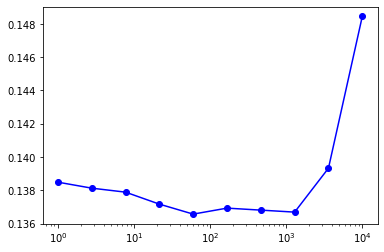

In [41]:
# YOUR CODE HERE
lams =np.logspace(0, 4, num=10)

logreglam =0

def kfoldLR(x,y):
    kx,ky =arrangeMat(x,y)
    
    tmpEX =[]
    tmpEY =[]
    lamErr =float('inf')
    
    for i in range(len(lams)):
        tmpErr =float('inf')
        for k in range(len(kx)):
            for j in range(1,len(kx[0])):
                tmpW =learnlogreg(kx[k][j],ky[k][j],lams[i])
                err =testlogreg(kx[k][0],ky[k][0],tmpW)
                if(err <tmpErr):
                    tmpErr =err
            if(tmpErr <lamErr):
                lamErr =tmpErr
                logreglam =lams[i]
        tmpEX.append(lams[i])
        tmpEY.append(tmpErr)


    plt.semilogx(tmpEX,tmpEY,'bo-')
    plt.show()
    #print('logreglam =={}'.format(logreglam))
    #print('lamErr =={}'.format(lamErr))

kfoldLR(trainX,trainYclass)

<div style="color: #000000;background-color: #FFEEFF">
    <font size=+2>Part III: Testing</font>
</div>

<div style="color: #000000;background-color: #FFFFEE">
The code below retrains ridge regression and logistic regression using the found values of lambda, above.  It then reports the average error for each on the **testing** data.
    
Perhaps more interestingly, it also reports the error rate if the ridge regression method is used to predict whether the review is positive.
</div>

In [42]:
wridge = learnridge(trainX,trainYreg,ridgelam)
wlogreg = learnlogreg(trainX,trainYclass,logreglam)

ridgemse = testridge(testX,testYreg,wridge)
logregerrrate = testlogreg(testX,testYclass,wlogreg)
ridgeerrrate = testlogreg(testX,testYclass,wridge)

print("mean squared error for ridge rgression = %f" % ridgemse)
print("classification error rate for logistic regression = %f" % logregerrrate)
print("classificationerror rate for ridge regression = %f" % ridgeerrrate)

mean squared error for ridge rgression = 6.351627
classification error rate for logistic regression = 0.135600
classificationerror rate for ridge regression = 0.168960


<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 6:</font> <font size=+1>(2 points)</font>
Given the results above, would you use ridge regression or logistic regression for this problem?  **Explain why.**
</div>

### Your answer here


I would use logistic regression because it results in a smaller error than ridge regression